# A Study on Classification Tree and Random Forest

### Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
np.random.seed(52)

### Data Generating Process

My data generating process (dgp) is based on the original dataset used by the authors which deals with loan and borrowers characteristics. It is collected under **Home Mortgagae Disclosure Act (HMDA)**, the year into considertaion is 2015. As the descriptive statistics of the paper was not comprehensive enough, I have taken percentages of various classes in every single categorical variable. These proportions along with the means and standard deviations of numerical variables is consistent with the original data. These all variables are stored in a dictionary called _**"stats_dict"**_ which is loaded below. This dgp is a simplified version of the original dgp with **10000** observations. 

Moreover, I have created dummy variables to indicate which one a set of categorical variables a data point belongs to. So, dummy variables are created for _applicant's sex_, _race_, _loan purpose_ and _loan type_. Further, Hispanic population, African-American population and unemployment rate are county-specific numerical variables. They are taken randomly in proportions based on percentages of each variable from top 25% counties and bottom 25% counties as given by the authors. With this dummy variables along the numerical variables, I create my dependent variable data-frame _**"X_with_dummy"**_.

The beta values are taken from the paper [Table 3, Panel B, column (1) ] and error term is taken arbitraryly.

Dependent variable _**y**_ is as follows,

$$ y = \beta_{0}x_{female} + \beta_{1}x_{others} + \beta_{3}x_{Amer-Ind} + \beta_{4}x_{Asian} +
        \beta_{5}x_{Black} + \beta_{7}x_{Race-others} + \beta_{9}x_{home} + \beta{10}x_{refinance} +
        \beta_{11}x_{FHA} + \beta_{12}x_{VA} + \\ \beta_{13}x_{FSA} + \beta_{14}x_{Income} + 
        \beta_{15}x_{loan-amt} + \beta_{c1}x_{Hisponic-popu} + \beta_{c2}x_{Amer-Af-Popu} + 
        \beta_{c3}x_{unempoyment-rate}$$

Variables of x_males, x_white, x_purchase and x_conventional are the base categories for dummies of applicant's sex, applicant's race, loan-purpose and loan-type.

From the distribution of y, it is defined that y is an indicator variable.

$$y = \begin{cases}y > 30 &  1: Shadow-Bank\\
                   y < 30 &  0: Traditional-Bank
    \end{cases}$$

In [4]:
stats_dict = np.load('stats_dict.npy', allow_pickle=True).item()
stats_dict



{'male_percent': 0.6667040818163431,
 'female_percent': 0.2757965985393267,
 'white_percent': 0.7893322348810146,
 'american_indian_percent': 0.0056901030222616614,
 'asian_percent': 0.0562785621428574,
 'black_percent': 0.050144595434575195,
 'home_purchase_percent': 0.5462790104187073,
 'home_improv_percent': 0.030798845213172815,
 'refinance_percent': 0.42292214436811987,
 'conventional_percent': 0.7297290190136025,
 'FHA_percent': 0.17020645750186106,
 'VA_percent': 0.0795952598535091,
 'FSA_percent': 0.020469263631027326,
 'loan_amount_avg': 247.17155322640366,
 'loan_amount_std': 217.16054674622413,
 'applicant_income_avg': 107.13825497859747,
 'applicant_income_std': 129.44754502060457}

In [5]:
male_percent = stats_dict['male_percent']
female_percent = stats_dict['female_percent']

white_percent = stats_dict['white_percent']
american_indian_percent = stats_dict['american_indian_percent']
asian_percent = stats_dict['asian_percent']
black_percent = stats_dict['black_percent']

home_purchase_percent = stats_dict['home_purchase_percent']
home_improv_percent = stats_dict['home_improv_percent']
refinance_percent = stats_dict['refinance_percent']

conventional_percent = stats_dict['conventional_percent']
FHA_percent = stats_dict['FHA_percent']
VA_percent = stats_dict['VA_percent']
FSA_percent = stats_dict['FSA_percent']

loan_amount_avg = stats_dict['loan_amount_avg']
loan_amount_std = stats_dict['loan_amount_std']

applicant_income_avg = stats_dict['applicant_income_avg']
applicant_income_std = stats_dict['applicant_income_std']

In [6]:
num_values = 10000

num_males = int(num_values*male_percent)
num_females = int(num_values*female_percent)
num_others = num_values - (num_females + num_males)
x_applicant_sex = np.concatenate([np.ones(num_males), 2*np.ones(num_females), 3*np.ones(num_others)])
np.random.shuffle(x_applicant_sex)

num_whites = int(num_values*white_percent)
num_american_indians = int(num_values*american_indian_percent)
num_asians = int(num_values*asian_percent)
num_blacks = int(num_values*black_percent)
num_others = num_values - (num_whites + num_american_indians + num_asians + num_blacks)
x_applicant_race = np.concatenate([np.ones(num_whites), 2*np.ones(num_american_indians),
                                  3*np.ones(num_asians), 4*np.ones(num_blacks), 5*np.ones(num_others)])
np.random.shuffle(x_applicant_race)

num_purchase = int(num_values*home_purchase_percent)
num_home_improv = int(num_values*home_improv_percent)
num_refinance = int(num_values*refinance_percent)
x_loan_purpose = np.concatenate([np.ones(num_purchase), 2*np.ones(num_home_improv), 3*np.ones(num_refinance)])
print(x_loan_purpose.shape)
x_loan_purpose = np.concatenate([x_loan_purpose, np.ones(num_values - len(x_loan_purpose))])
np.random.shuffle(x_loan_purpose)

num_conventional = int(num_values*conventional_percent)
num_FHA = int(num_values*FHA_percent)
num_VA = int(num_values*VA_percent)
num_FSA = int(num_values*FSA_percent)
x_loan_type = np.concatenate([np.ones(num_conventional), 2*np.ones(num_FHA), 3*np.ones(num_VA), 4*np.ones(num_FSA)])
print(x_loan_type.shape)
x_loan_type = np.concatenate([x_loan_type, np.ones(num_values - len(x_loan_type))])
np.random.shuffle(x_loan_type)

x_loan_amount = np.random.normal(loan_amount_avg, loan_amount_std, size = num_values)
x_applicant_income = np.random.normal(applicant_income_avg, applicant_income_std, size = num_values)

(9998,)
(9998,)


In [7]:
# Numerical covariates - County variables
x_hisponic_cent = np.concatenate([np.random.normal(2.40, size=5000), np.random.normal(8.80, size=5000)])
x_african_american_cent = np.concatenate([np.random.normal(1.06, size=5000), np.random.normal(2.83, size=5000)])
x_unemployment_rate = np.concatenate([np.random.normal(6.40, size=5000), np.random.normal(7.50, size=5000)])
county_assign = np.arange(num_values)
np.random.shuffle(county_assign)

X = pd.DataFrame({'applicant_sex': x_applicant_sex, 'applicant_race': x_applicant_race,
                 'loan_purpose': x_loan_purpose, 'loan_type': x_loan_type,
                 'loan_amount_000s': x_loan_amount, 'applicant_income_000s': x_applicant_income,
                 'hisponic_population': x_hisponic_cent[county_assign], 'african_amer_pop': x_african_american_cent[county_assign], 
                 'unemp_rate': x_unemployment_rate[county_assign]})
X

,applicant_sex,applicant_race,loan_purpose,loan_type,loan_amount_000s,applicant_income_000s,hisponic_population,african_amer_pop,unemp_rate
0,2.0,1.0,3.0,4.0,294.317033,247.943429,7.852231,1.426929,7.478155
1,1.0,1.0,1.0,2.0,423.348033,85.939572,2.447757,1.845211,7.045539
2,1.0,4.0,1.0,1.0,-44.624067,223.097788,0.782683,-0.591626,7.664218
3,2.0,5.0,3.0,3.0,512.661172,207.261058,2.810321,0.493730,4.810901
4,2.0,1.0,3.0,1.0,80.391745,402.699774,10.204821,2.532785,7.044486
...,...,...,...,...,...,...,...,...,...
9995,2.0,1.0,1.0,1.0,129.858711,139.927721,0.020925,1.279827,4.619505
9996,1.0,1.0,3.0,2.0,310.476959,-126.018218,1.504925,0.704952,6.425754
9997,2.0,1.0,3.0,1.0,10.117781,122.439900,9.385109,1.076809,8.736582
9998,3.0,1.0,3.0,1.0,148.626139,352.270884,2.099965,1.572109,7.796967


### Dummy varaiables 

In [8]:
X_with_dummy = X.copy()

In [9]:
# Applicant_sex
X_with_dummy.loc[:, 'is_male'] = 0
X_with_dummy.loc[:, 'is_female'] = 0
X_with_dummy.loc[:, 'is_sex_others'] = 0

X_with_dummy.loc[X.applicant_sex == 1, 'is_male'] = 1
X_with_dummy.loc[X.applicant_sex == 2, 'is_female'] = 1
X_with_dummy.loc[X.applicant_sex == 3, 'is_sex_others'] = 1

In [10]:
# Applicant race
X_with_dummy.loc[:, 'is_white'] = 0
X_with_dummy.loc[:, 'is_american_indian'] = 0
X_with_dummy.loc[:, 'is_asian'] = 0
X_with_dummy.loc[:, 'is_black_african'] = 0
X_with_dummy.loc[:, 'is_race_others'] = 0

X_with_dummy.loc[X.applicant_race == 1, 'is_white'] = 1
X_with_dummy.loc[X.applicant_race == 2, 'is_american_indian'] = 1
X_with_dummy.loc[X.applicant_race == 3, 'is_asian'] = 1
X_with_dummy.loc[X.applicant_race == 4, 'is_black_african'] = 1
X_with_dummy.loc[X.applicant_race == 5, 'is_race_others'] = 1

In [11]:
# Purpose
X_with_dummy.loc[:, 'is_purchase'] = 0
X_with_dummy.loc[:, 'is_home'] = 0
X_with_dummy.loc[:, 'is_refinance'] = 0

X_with_dummy.loc[X.loan_purpose == 1, 'is_purchase'] = 1
X_with_dummy.loc[X.loan_purpose == 2, 'is_home'] = 1
X_with_dummy.loc[X.loan_purpose == 3, 'is_refinance'] = 1

In [12]:
# Type
X_with_dummy.loc[:, 'is_conventional'] = 0
X_with_dummy.loc[:, 'is_FHA'] = 0
X_with_dummy.loc[:, 'is_VA'] = 0
X_with_dummy.loc[:, 'is_FSA'] = 0

X_with_dummy.loc[X.loan_type == 1, 'is_conventional'] = 1
X_with_dummy.loc[X.loan_type == 2, 'is_FHA'] = 1
X_with_dummy.loc[X.loan_type == 3, 'is_VA'] = 1
X_with_dummy.loc[X.loan_type == 4, 'is_FSA'] = 1

In [13]:
X_with_dummy

,applicant_sex,applicant_race,loan_purpose,loan_type,loan_amount_000s,applicant_income_000s,hisponic_population,african_amer_pop,unemp_rate,is_male,...,is_asian,is_black_african,is_race_others,is_purchase,is_home,is_refinance,is_conventional,is_FHA,is_VA,is_FSA
0,2.0,1.0,3.0,4.0,294.317033,247.943429,7.852231,1.426929,7.478155,0,...,0,0,0,0,0,1,0,0,0,1
1,1.0,1.0,1.0,2.0,423.348033,85.939572,2.447757,1.845211,7.045539,1,...,0,0,0,1,0,0,0,1,0,0
2,1.0,4.0,1.0,1.0,-44.624067,223.097788,0.782683,-0.591626,7.664218,1,...,0,1,0,1,0,0,1,0,0,0
3,2.0,5.0,3.0,3.0,512.661172,207.261058,2.810321,0.493730,4.810901,0,...,0,0,1,0,0,1,0,0,1,0
4,2.0,1.0,3.0,1.0,80.391745,402.699774,10.204821,2.532785,7.044486,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,1.0,1.0,1.0,129.858711,139.927721,0.020925,1.279827,4.619505,0,...,0,0,0,1,0,0,1,0,0,0
9996,1.0,1.0,3.0,2.0,310.476959,-126.018218,1.504925,0.704952,6.425754,1,...,0,0,0,0,0,1,0,1,0,0
9997,2.0,1.0,3.0,1.0,10.117781,122.439900,9.385109,1.076809,8.736582,0,...,0,0,0,0,0,1,1,0,0,0
9998,3.0,1.0,3.0,1.0,148.626139,352.270884,2.099965,1.572109,7.796967,0,...,0,0,0,0,0,1,1,0,0,0


In [14]:
# Loan and borrower characteristics
betas = [0.163, -4.636, 16.27, -0.227, 3.923, 0.405, 1.363, 7.438, -24.98, -13.26, -2.056, 9.418, 2.331, -3.036, -0.00857, 0.00835]

# County characteristics
betas_1 = [2.0, 2.0, 2.0]

len(betas), len(betas_1)

(16, 3)

In [15]:
eps = np.random.normal(scale = 4,size = num_values)

In [16]:
y = betas[0]*X_with_dummy.is_female + betas[1]*X_with_dummy.is_sex_others + \
    betas[3]*X_with_dummy.is_american_indian + betas[4]*X_with_dummy.is_asian + \
    betas[5]*X_with_dummy.is_black_african + betas[7]*X_with_dummy.is_race_others + \
    betas[9]*X_with_dummy.is_home + betas[10]*X_with_dummy.is_refinance + \
    betas[11]*X_with_dummy.is_FHA + betas[12]*X_with_dummy.is_VA + betas[13]*X_with_dummy.is_FSA + \
    betas[14]*X_with_dummy.applicant_income_000s + betas[15]*X_with_dummy.loan_amount_000s + \
    betas_1[0]*X_with_dummy.hisponic_population + betas_1[1]*X_with_dummy.african_amer_pop + betas_1[2]*X_with_dummy.unemp_rate + \
    eps

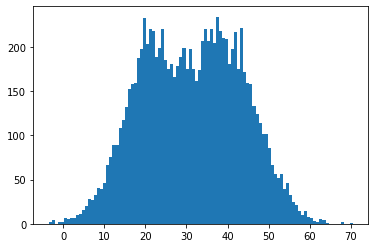

In [17]:
plt.hist(y, bins = 100);

In [18]:
y_class = np.where(y > 30, np.ones(num_values), np.zeros(num_values))

In [19]:
Y = pd.DataFrame({'y': y, 'y_class':y_class})
Y

,y,y_class
0,31.549360,1.0
1,34.105564,1.0
2,13.214264,0.0
3,25.321486,0.0
4,41.532718,1.0
...,...,...
9995,4.878992,0.0
9996,29.398602,0.0
9997,36.112152,1.0
9998,12.506675,0.0


## Training and testing data

In [20]:
## Split the data into training and testing data-sets 
X_train, X_test, y_train, y_test = train_test_split(X_with_dummy, Y.y_class, random_state = 60)

#create a decision tree and fit it to training data
clf_dt = DecisionTreeClassifier(random_state = 60)
clf_dt = clf_dt.fit(X_train,y_train)

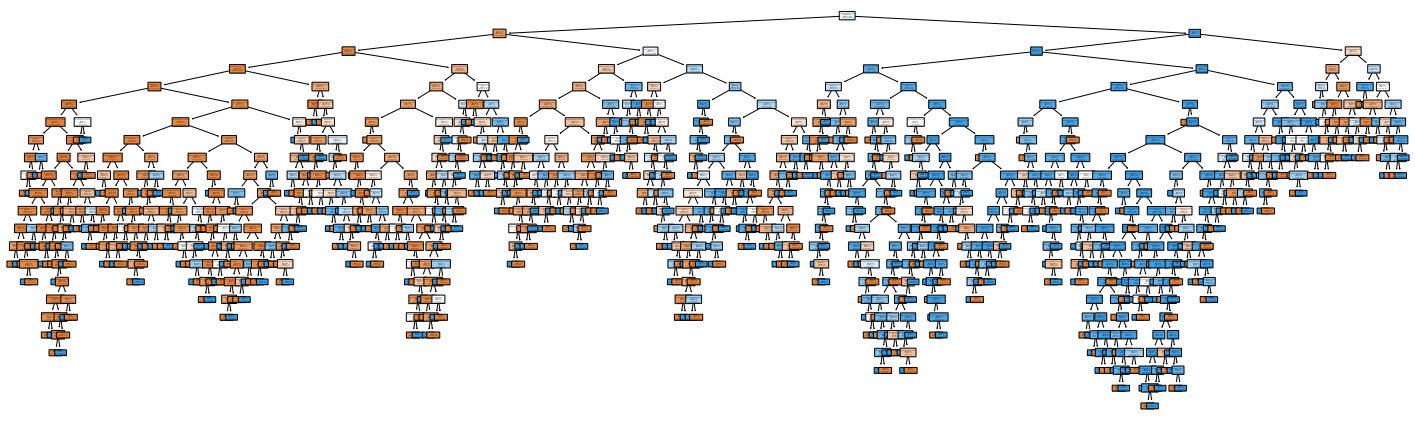

In [21]:
##plot the long tree
plt.figure(figsize = (25,7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Traditional bank","Shadow bank"],
         feature_names = X_with_dummy.columns);

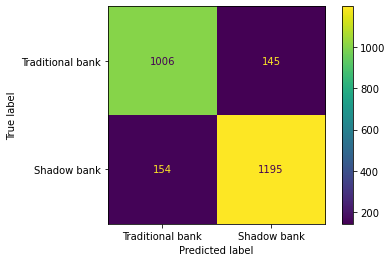

In [22]:
##Plot confusion matrix
plot_confusion_matrix(clf_dt,X_test,y_test,display_labels=["Traditional bank", "Shadow bank"])

In [23]:
y_pred = clf_dt.predict(X_test)
accuracy_long_tree = accuracy_score(y_test, y_pred )
accuracy_long_tree

0.8804

### Interpretation
The long tree is very hard to interpret but the confusion matrix tells us that the model has predicted 87.4% of traditional bank borrowers correctly. Similarly, it has correctly predicted 88.5% of shadow bank borrowers. The accuracy of this model is **88.04%**. 

### Cost complexity pruning

Decision trees are known for the problem of overfitting, thus we need to prune the tree in order to optimize it. Pruning a tree with cost complexity pruning can simplify the whole process of finding a smaller tree that improves the accuracy with the testing data set.

We need to find the value of pruning parameter _"alpha"_ which controls the pruning. We find out the value of _"alpha"_ by plotting the accuracy of the tree as a function of different values. It is done for both, training and testing datasets.

Here the maximum value of alpha is omitted as it will lead to pruning of all leaves, leaving only a root and not a tree.

In [24]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
#print(ccp_alphas, ccp_alphas.shape)

In [25]:
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state= 0,
                                   ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

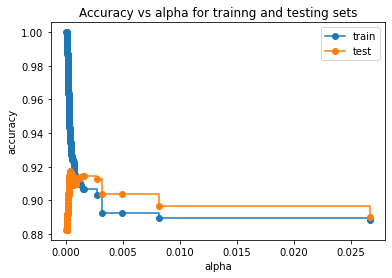

In [26]:
train_scores = [clf_dt.score(X_train,y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test,y_test) for clf_dt in clf_dts]

fid, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for trainng and testing sets")
ax.plot(ccp_alphas,train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas,test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Here, it can be seen that the accuracy of training data-set is declining from 1.0 which is 100% to 88% and the testing accuracy is increasing till 92% and decline from there. I need to find such a value of alpha which gives me highest testing accuracy. So, I take the argmax of _ccp_alpha_ and _test_scores_ and use that alpha value further in the analysis.

Further, to improve the performance of the model, I use cross-validation with the alpha calculated below. **Cross-Validation** is a resampling method used to improve the model by randomly spliting the sample into training and testing data-sets. It is a popular method because it is simple to understand and generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

In [27]:
ccp_alphas[np.argmax(test_scores)]

0.00037491216655822926

<AxesSubplot:xlabel='tree'>

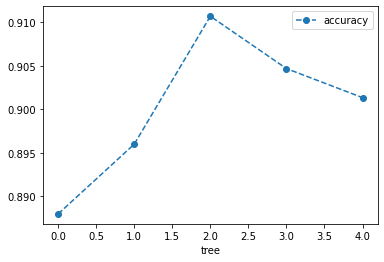

In [28]:
## Cross-validation

clf_dt = DecisionTreeClassifier(random_state = 42, ccp_alpha= 0.00037491216655822926)
scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)

df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x = 'tree', y= 'accuracy', marker= 'o', linestyle= '--')

This graph shows that using different training and testing data with same alpha results in different accuracies which means the pruning parameter is sensitive to datasets. So, instead of picking a single training and testing dataset, lets try to use cross-validation to find the optimal alpha

<AxesSubplot:xlabel='alpha'>

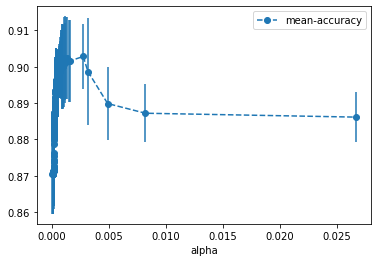

In [29]:
## create an array to store the results of each fold during cross validation
alpha_loop_values = []

## for each candidate value for alpha, we will run 5-fold cross validations. 
## then we will store all the mean and standard deviation of the scores (accuracies) for each call
## to cross-val-score in alpha_loop_values
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 4, n_jobs=6)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
## now we draw a graph of mean and standard deviations of the scores 
## for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values,
                            columns = ['alpha','mean-accuracy','std'])

alpha_results.plot(x = 'alpha',
                   y = 'mean-accuracy',
                   yerr = 'std',
                   marker = 'o',
                   linestyle = '--')

In [30]:
# To find the ideal value of alpha 
alpha_results.loc[alpha_results['mean-accuracy'].idxmax()].alpha

0.002758293022190019

In [31]:
# We will use the value of ccp_alpha from above to prune the long tree
clf_dt_prunned = DecisionTreeClassifier(random_state = 42, 
                                        ccp_alpha = 0.002758293022190019)
clf_dt_prunned = clf_dt_prunned.fit(X_train,y_train)

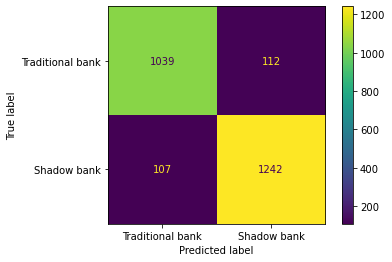

In [32]:
plot_confusion_matrix(clf_dt_prunned,
                     X_test,
                     y_test,
                     display_labels = ["Traditional bank","Shadow bank"])

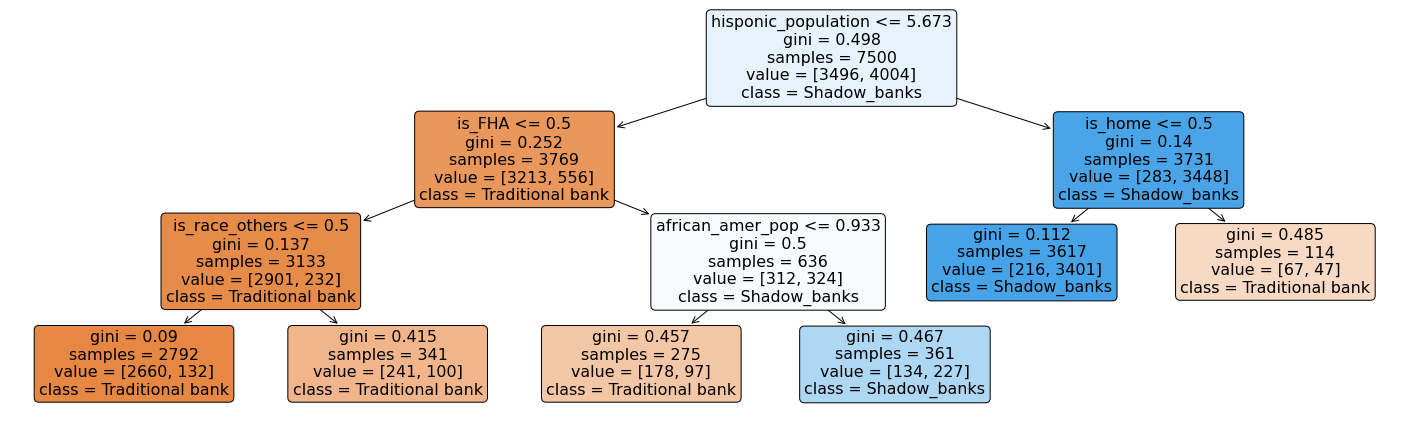

In [33]:
plt.figure(figsize = (25,7.5))
plot_tree(clf_dt_prunned,
          filled = True,
          rounded = True,
          class_names = ["Traditional bank","Shadow_banks"],
          feature_names = X_with_dummy.columns);
plt.savefig("pruned_tree.pdf")

In [34]:
y_pred = clf_dt_prunned.predict(X_test)
y_pred

array([0., 1., 0., ..., 1., 0., 1.])

In [35]:
accuracy = accuracy_score(y_test, y_pred )
accuracy

0.9124

From the confusion matrix, we can calculate that the traditional bank borrowers are 1039+112 = 1151, 1039 i.e 90.2% borrowers are correctly classified. For the Shadow bank borrowers which are 107+1242 = 1349, 1242 i.e 92.06% are correctly classified, an improvement of around 2% in both the classes.

**Pruned-Tree Analysis**:
* It can be seen the majority class is **shadow bank** which is the class of the first node. The tree is branching from the county-specific Hisponic population variable with the majority class of shadow bank. This supports the authors results under examination. Further branching is happening from loan type and loan purpose variables with one variable inclined to traditional bank and another to shadow bank.

* The gini index at the start of the tree is 0.498 which is high enough to start the branching but such large value of gini also gives weak class majority. It can be seen that as the gini index goes to a smaller number, the color of that node becomes darker. This implies that the specific node contains predominantly observations from a single class. 

The **accuracy** of the model is increased from 88.04% to **91.24%** due to pruning of the decision tree

## Random Forest

For random forest, I have used sklearn's ensemble _RandomForestClassifier()_. the dgp is the same as above. I split the data into training and testing data-sets.

Here, I create 120 decision trees with n_estimator set to 120. Further, I predict y with "y_pred" and count the values of 0s and 1s to know the majority class of random forest. Finally I plot the confusion matrix and the accuracy of the model.

In [36]:
##Split the data into training and testing data-sets
X_train, X_test, y_train, y_test = train_test_split(X_with_dummy, Y.y_class, random_state = 60)

In [37]:
## Applying Random-Forest classifier with 120 trees with the tarining and testing data-sets
rf = RandomForestClassifier(n_estimators = 120, random_state = 60, n_jobs= 6, verbose = 1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.1s finished


RandomForestClassifier(n_estimators=120, n_jobs=6, random_state=60, verbose=1)

In [38]:
y_pred = rf.predict(X_test)
y_pred

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.0s finished


array([0., 1., 0., ..., 1., 0., 1.])

In [39]:
y_pred.tolist().count(0), y_pred.tolist().count(1)

(1146, 1354)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.0s finished


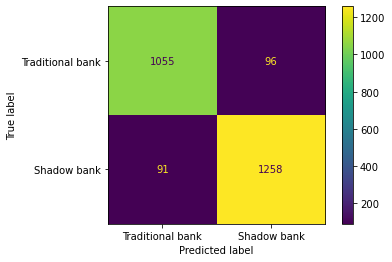

In [40]:
plot_confusion_matrix(rf,
                     X_test,
                     y_test,
                     display_labels = ["Traditional bank","Shadow bank"])

In [41]:
print(classification_report(y_test, y_pred))
print( "Accuracy_Score ",accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      1151
         1.0       0.93      0.93      0.93      1349

    accuracy                           0.93      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.93      0.93      0.93      2500

Accuracy_Score  0.9252


**Interpretation**:

From the counts of 0s and 1s, it is clear that the majority class is of 1s (1354 as against 1146) which is of **shadow bank**. This is consistent with the classification tree analysis. 

The confusion matrix states that the model correctly classifies **91.6%** of traditional bank borrowers and **93.2%** of shadow bank borrowers. The preditions have improved from earlier. In random forest, one can also use ccp_alpha however with the use of ccp_alpha, the results stays unchanged. 

The use of random forest has increased the accuracy of the model from 91.2% to **92.5%**.

## Simulation Study : Changing the beta values

In this simulation study, I have changed the values of beta coefficents to see overall impact on the model. I also wanted to see if the majority class changes if beta values are changed.

So the y variable is the same,

$$ y_1 = \beta_{0}x_{female} + \beta_{1}x_{others} + \beta_{3}x_{Amer-Ind} + \beta_{4}x_{Asian} +
        \beta_{5}x_{Black} + \beta_{7}x_{Race-others} + \beta_{9}x_{home} + \beta{10}x_{refinance} +
        \beta_{11}x_{FHA} + \beta_{12}x_{VA} + \\ \beta_{13}x_{FSA} + \beta_{14}x_{Income} + 
        \beta_{15}x_{loan-amt} + \beta_{c1}x_{Hisponic-popu} + \beta_{c2}x_{Amer-Af-Popu} + 
        \beta_{c3}x_{unempoyment-rate}$$
        
Variables of x_males, x_white, x_purchase and x_conventional are still the base categories for dummies of applicant's sex, applicant's race, loan-purpose and loan-type.

From the distribution of y, it is defined that y is an indicator variable.

$$y_1 = \begin{cases}y_1 > -5 &  1: Shadow-Bank\\
                   y_1 < -5 &  0: Traditional-Bank
    \end{cases}$$

In [42]:
# Numerical covariates - County variables
x_hisponic_cent = np.concatenate([np.random.normal(2.40, size=5000), np.random.normal(8.80, size=5000)])
x_african_american_cent = np.concatenate([np.random.normal(1.06, size=5000), np.random.normal(2.83, size=5000)])
x_unemployment_rate = np.concatenate([np.random.normal(6.40, size=5000), np.random.normal(7.50, size=5000)])
county_assign = np.arange(num_values)
np.random.shuffle(county_assign)

X = pd.DataFrame({'applicant_sex': x_applicant_sex, 'applicant_race': x_applicant_race,
                 'loan_purpose': x_loan_purpose, 'loan_type': x_loan_type,
                 'loan_amount_000s': x_loan_amount, 'applicant_income_000s': x_applicant_income,
                 'hisponic_population': x_hisponic_cent[county_assign], 'african_amer_pop': x_african_american_cent[county_assign], 
                 'unemp_rate': x_unemployment_rate[county_assign]})
X

,applicant_sex,applicant_race,loan_purpose,loan_type,loan_amount_000s,applicant_income_000s,hisponic_population,african_amer_pop,unemp_rate
0,2.0,1.0,3.0,4.0,294.317033,247.943429,9.557256,3.049126,6.751999
1,1.0,1.0,1.0,2.0,423.348033,85.939572,9.312414,2.283303,6.590465
2,1.0,4.0,1.0,1.0,-44.624067,223.097788,8.154374,1.795839,6.523637
3,2.0,5.0,3.0,3.0,512.661172,207.261058,8.044603,5.727903,7.733771
4,2.0,1.0,3.0,1.0,80.391745,402.699774,2.944824,0.397821,4.856965
...,...,...,...,...,...,...,...,...,...
9995,2.0,1.0,1.0,1.0,129.858711,139.927721,2.018594,2.081608,7.792276
9996,1.0,1.0,3.0,2.0,310.476959,-126.018218,0.570555,1.223242,6.373910
9997,2.0,1.0,3.0,1.0,10.117781,122.439900,9.551044,4.239887,5.885079
9998,3.0,1.0,3.0,1.0,148.626139,352.270884,8.589867,2.193260,8.392850


In [43]:
# Loan and borrower characteristics
betas = [0.005, -2.6, -18.27, -1.5, 15.3, -1.45, 2.6, 15.5, -30.3, -9.8, -4.5, 8.6, 2.8, -5.2, -0.01, 0.055]

# County characteristics
betas_1 = [1.0, -1.5, -3.0]

len(betas), len(betas_1)

(16, 3)

In [44]:
eps = np.random.normal(scale = 6,size = num_values)

In [45]:
y1 = betas[0]*X_with_dummy.is_female + betas[1]*X_with_dummy.is_sex_others + \
    betas[3]*X_with_dummy.is_american_indian + betas[4]*X_with_dummy.is_asian + \
    betas[5]*X_with_dummy.is_black_african + betas[7]*X_with_dummy.is_race_others + \
    betas[9]*X_with_dummy.is_home + betas[10]*X_with_dummy.is_refinance + \
    betas[11]*X_with_dummy.is_FHA + betas[12]*X_with_dummy.is_VA + betas[13]*X_with_dummy.is_FSA + \
    betas[14]*X_with_dummy.applicant_income_000s + betas[15]*X_with_dummy.loan_amount_000s + \
    betas_1[0]*X_with_dummy.hisponic_population + betas_1[1]*X_with_dummy.african_amer_pop + betas_1[2]*X_with_dummy.unemp_rate + \
    eps

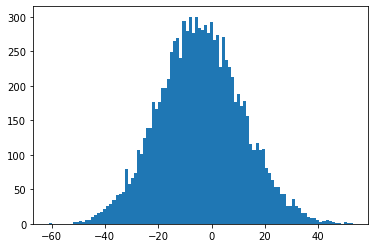

In [46]:
plt.hist(y1, bins = 100);

In [47]:
y_class = np.where(y1 > -5, np.ones(num_values), np.zeros(num_values))

In [48]:
Y = pd.DataFrame({'y': y1, 'y_class':y_class})
Y

,y,y_class
0,-4.044994,1.0
1,4.420076,1.0
2,-34.071280,0.0
3,18.840263,1.0
4,-8.439401,0.0
...,...,...
9995,-5.051181,0.0
9996,13.560076,1.0
9997,-15.686173,0.0
9998,-29.473957,0.0


### Training and testing datasets

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_with_dummy, Y.y_class, random_state = 60)

#create a decision tree and fit it to training data
clf_dt = DecisionTreeClassifier(random_state = 60)
clf_dt = clf_dt.fit(X_train,y_train)

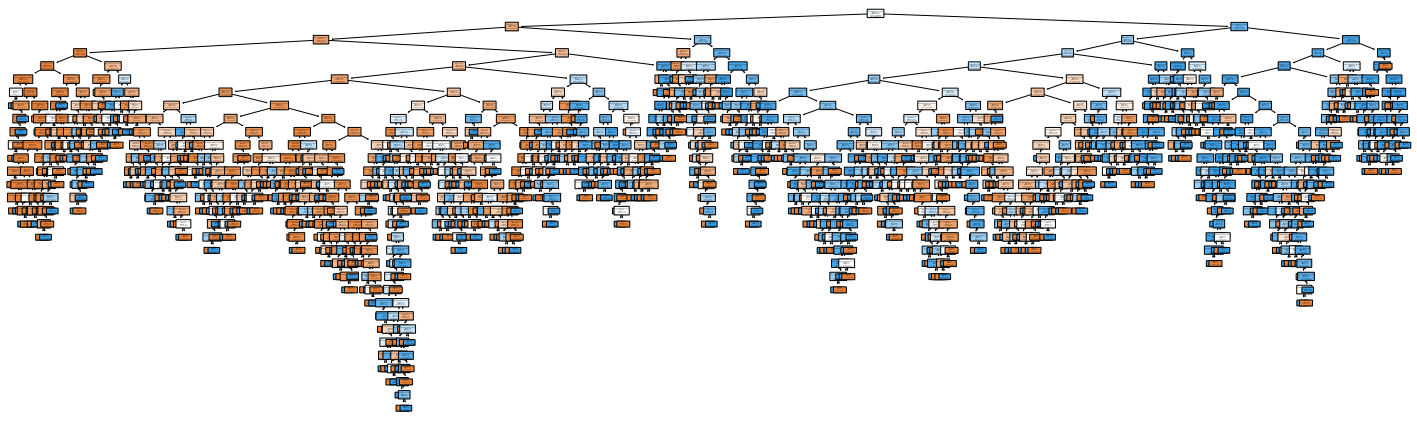

In [50]:
##plot the long tree
plt.figure(figsize = (25,7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Traditional bank","Shadow bank"],
         feature_names = X_with_dummy.columns);

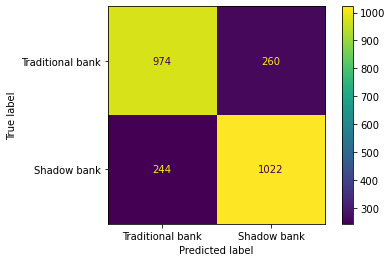

In [51]:
##Plot confusion matrix
plot_confusion_matrix(clf_dt,X_test,y_test,display_labels=["Traditional bank", "Shadow bank"])

In [52]:
y_pred = clf_dt.predict(X_test)
accuracy_long_tree = accuracy_score(y_test, y_pred )
accuracy_long_tree

0.7984

**Interpretation**: 

The long tree is very hard to interpret but the confusion matrix tells us that the model has predicted 78.9% of traditional bank borrowers correctly. Similarly, it has correctly predicted 80.7% of shadow bank borrowers. The accuracy of this model is 79.84%

### Cost Complexity Pruning

In [53]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
#print(ccp_alphas, ccp_alphas.shape)

In [54]:
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state= 0,
                                   ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

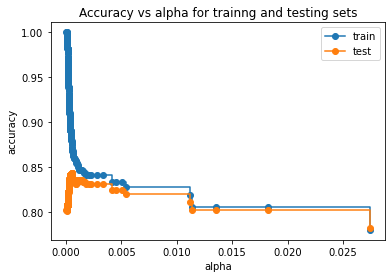

In [55]:
train_scores = [clf_dt.score(X_train,y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test,y_test) for clf_dt in clf_dts]

fid, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for trainng and testing sets")
ax.plot(ccp_alphas,train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas,test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Here, it can be seen that the accuracy of training data-set is declining from 1.0 which is 100% to 75% and the testing accuracy is increasing till 74% and decline from there. I need to find such a value of alpha which gives me highest testing accuracy. So, I take the argmax of ccp_alpha and test_scores and use that alpha value further in the analysis

In [56]:
ccp_alphas[np.argmax(test_scores)]

0.0005302431670708516

<AxesSubplot:xlabel='tree'>

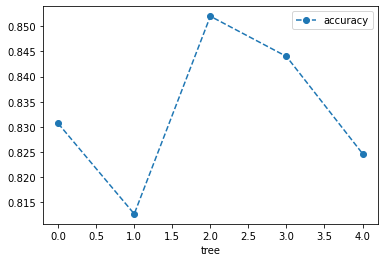

In [57]:
## Cross-validation

clf_dt = DecisionTreeClassifier(random_state = 42, ccp_alpha= 0.0005302431670708516)
scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)

df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x = 'tree', y= 'accuracy', marker= 'o', linestyle= '--')

I use cross-validation to find the optimal value of _ccp_alpha_

<AxesSubplot:xlabel='alpha'>

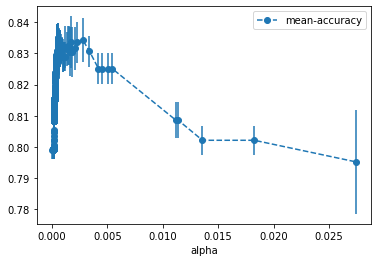

In [58]:
## create an array to store the results of each fold during cross validation
alpha_loop_values = []

## for each candidate value for alpha, we will run 5-fold cross validations. 
## then we will store all the mean and standard deviation of the scores (accuracies) for each call
## to cross-val-score in alpha_loop_values
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 4, n_jobs=6)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
## now we draw a graph of mean and standard deviations of the scores 
## for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values,
                            columns = ['alpha','mean-accuracy','std'])

alpha_results.plot(x = 'alpha',
                   y = 'mean-accuracy',
                   yerr = 'std',
                   marker = 'o',
                   linestyle = '--')

In [59]:
# To find the ideal value of alpha 
alpha_results.loc[alpha_results['mean-accuracy'].idxmax()].alpha

0.002795318756171502

In [60]:
# We will use the value of ccp_alpha from above to prune the long tree
clf_dt_prunned = DecisionTreeClassifier(random_state = 42, 
                                        ccp_alpha = 0.002795318756171502)
clf_dt_prunned = clf_dt_prunned.fit(X_train,y_train)

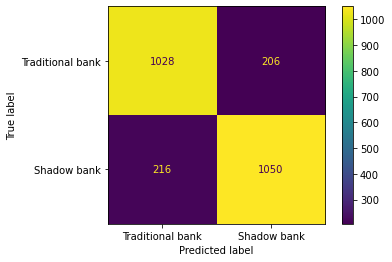

In [61]:
plot_confusion_matrix(clf_dt_prunned,
                     X_test,
                     y_test,
                     display_labels = ["Traditional bank","Shadow bank"])

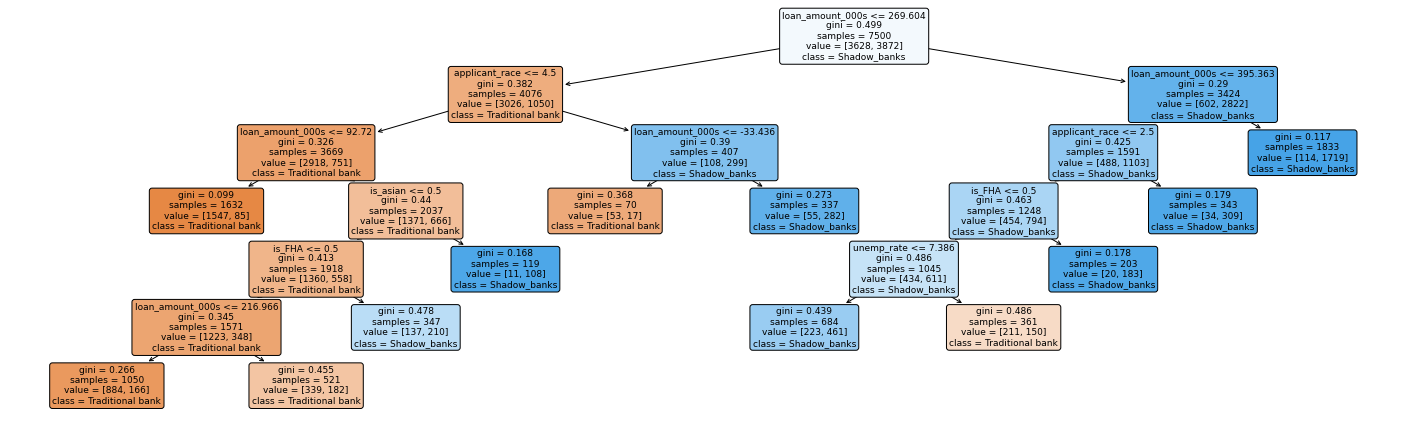

In [62]:
plt.figure(figsize = (25,7.5))
plot_tree(clf_dt_prunned,
          filled = True,
          rounded = True,
          class_names = ["Traditional bank","Shadow_banks"],
          feature_names = X_with_dummy.columns);
plt.savefig("pruned_tree.pdf")

In [63]:
y_pred = clf_dt_prunned.predict(X_test)
y_pred

array([0., 0., 0., ..., 1., 0., 1.])

In [64]:
accuracy = accuracy_score(y_test, y_pred )
accuracy

0.8312

From the confusion matrix, we can calculate that the traditional bank borrowers are 1028+206 = 1234, 1039 i.e **83.3%** borrowers are correctly classified. For the Shadow bank borrowers which are 216+1050=1266, 1082 i.e **82.9%** are correctly classified, an improvement of around 4% in both the classes.

**Pruned-Tree Analysis**:

It can be seen the majority class is **shadow bank** which is the class of the first node. The tree is branching from **loan amount_000s** variable with the majority class of shadow bank. This supports the authors results under examination. Further branching is happening from loan type and racial groups variables with one variable inclined to traditional bank and another to shadow bank.

The gini index at the start of the tree is 0.492 which is high enough to start the branching but such large value of gini also gives weak class majority. It can be seen that as the gini index goes to a smaller number, the color of that node becomes darker. This implies that the specific node contains predominantly observations from a single class.

The accuracy of the model is increased from 79.84% to **82.9%** due to pruning of the decision tree.

The results from both pruned trees are similar, however, the accuracy has a considerable change. This is due to the beta values being changed. In mostly of the cases, the beta value is lowered which lowers the significance of the variables.  

### Random forest

In [65]:
##Split the data into training and testing data-sets
X_train, X_test, y_train, y_test = train_test_split(X_with_dummy, Y.y_class, random_state = 60)

In [66]:
## Applying Random-Forest classifier with 120 trees with the tarining and testing data-sets
rf = RandomForestClassifier(n_estimators = 120, random_state = 60, n_jobs= 6, verbose = 1, ccp_alpha=0.00095)
rf.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.2s finished


RandomForestClassifier(ccp_alpha=0.00095, n_estimators=120, n_jobs=6,
                       random_state=60, verbose=1)

In [67]:
y_pred = rf.predict(X_test)
y_pred

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.0s finished


array([0., 0., 0., ..., 0., 0., 1.])

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:    0.0s finished


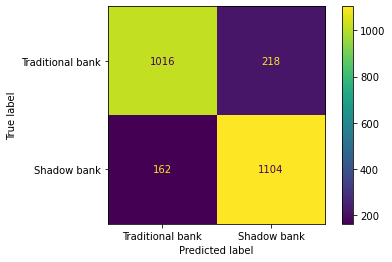

In [68]:
plot_confusion_matrix(rf,
                     X_test,
                     y_test,
                     display_labels = ["Traditional bank","Shadow bank"])

In [69]:
print(classification_report(y_test, y_pred))
print( "Accuracy_Score: ",accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      1234
         1.0       0.84      0.87      0.85      1266

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500

Accuracy_Score:  0.848


**Interpretation**:

The confusion matrix states that the model correctly classifies **82.3%** of traditional bank borrowers and **87.2%** of shadow bank borrowers. The preditions have improved from earlier. In this random forest, I have used _ccp_alpha_ which was derived during pruning of the classification tree .

The confusion matrix also states that the majority class is **Shadow banks** with 1104 borrowers as against 1016 traditional bank borrowers. 

The use of random forest has increased the accuracy of the model from **82.9%** to **84.8%**.